In [1]:
import pandas as pd
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, BayesianRidge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.svm import SVR
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from tqdm import tqdm
import sys
from pvlib import solarposition
import sys
import os
sys.path.append(os.path.abspath('../common/'))
import common_functions_by_date as cfbd
import datetime
import predictions_algorithmes as pa

In [2]:
weather_path = 'Input/weather_train_set4.csv'
demand_path = 'Input/demand_train_set4.csv'
solar_path = 'Input/pv_train_set4.csv'
dp = cfbd.DataPreprocesser(weather_path, demand_path, solar_path)
dp.load_df()
dp.remove_nan()
dp.interpolate_df()
dp.get_zenith_angle()
dp.get_poa_and_ghi_irradiance()
dp.df.head()

,demand_MW,irradiance_Wm-2,pv_power_mw,panel_temp_C,temp_location3,temp_location6,temp_location2,temp_location4,temp_location5,temp_location1,...,solar_location5,solar_location1,week,dow,date,hour,sp,zenith_angle,GHI,POA
datetime,,,,,,,,,,,,,,,,,,,,,
2017-11-03 00:00:00,2.19,0.0,0.0,7.05,7.46,13.20,9.640,6.680,13.090,8.560,...,0.0,0.0,44,4,2017-11-03,0,1.0,122.821452,0.0,0.0
2017-11-03 00:30:00,2.14,0.0,0.0,7.38,7.30,13.26,9.675,6.475,13.150,8.625,...,0.0,0.0,44,4,2017-11-03,0,2.0,115.780705,0.0,0.0
2017-11-03 01:00:00,2.01,0.0,0.0,7.70,7.14,13.32,9.710,6.270,13.210,8.690,...,0.0,0.0,44,4,2017-11-03,1,3.0,108.668070,0.0,0.0
2017-11-03 01:30:00,1.87,0.0,0.0,7.48,7.00,13.34,9.720,6.090,13.255,8.715,...,0.0,0.0,44,4,2017-11-03,1,4.0,101.505357,0.0,0.0
2017-11-03 02:00:00,1.86,0.0,0.0,7.20,6.86,13.36,9.730,5.910,13.300,8.740,...,0.0,0.0,44,4,2017-11-03,2,5.0,94.307845,0.0,0.0


In [3]:
dp.df.tail()

,demand_MW,irradiance_Wm-2,pv_power_mw,panel_temp_C,temp_location3,temp_location6,temp_location2,temp_location4,temp_location5,temp_location1,...,solar_location5,solar_location1,week,dow,date,hour,sp,zenith_angle,GHI,POA
datetime,,,,,,,,,,,,,,,,,,,,,
2020-07-02 21:30:00,2.28,0.0,0.0,9.08,11.89,14.605,12.490,12.390,14.690,12.715,...,0.0,0.0,27,3,2020-07-02,21,44.0,157.928910,0.0,0.0
2020-07-02 22:00:00,2.03,0.0,0.0,8.91,12.05,14.490,12.460,12.220,14.600,12.840,...,0.0,0.0,27,3,2020-07-02,22,45.0,153.454955,0.0,0.0
2020-07-02 22:30:00,1.80,0.0,0.0,8.94,12.20,14.425,12.455,12.115,14.555,12.845,...,0.0,0.0,27,3,2020-07-02,22,46.0,147.953176,0.0,0.0
2020-07-02 23:00:00,1.72,0.0,0.0,8.77,12.35,14.360,12.450,12.010,14.510,12.850,...,0.0,0.0,27,3,2020-07-02,23,47.0,141.870348,0.0,0.0
2020-07-02 23:30:00,1.61,0.0,0.0,8.33,12.35,14.360,12.450,12.010,14.510,12.850,...,0.0,0.0,27,3,2020-07-02,23,48.0,135.449196,0.0,0.0


In [3]:
first_day_pred=datetime.datetime(2020,7,3).date()

In [4]:
mp = cfbd.MLPredictor(dp,first_day_pred)
mp.get_demand_previous_week()
mp.get_weather_prediction(weather_path)
mp.pred_demand_with_forecast_method_and_average_with_previous_weeks(dp.df, 'Output/rectify_forecast', first_day_pred, 'demand_MW', compute_forecast=False)
mp.predict_pv_power_smooth_and_square_irr()

smooth_phaze : -3
weather dephasage : 1
smooth_phaze : -3


In [5]:
bpd = cfbd.BatteryPowerDispatcher
B = bpd.get_all_dispatch_in_a_week(bpd,mp.predicted_df, first_day_pred)
B_final = bpd.format_dispatching_for_competition(B, mp.predicted_df.index)

In [6]:
B.sum()

20200703    1.776357e-15
20200704    6.661338e-16
20200705    1.554312e-15
20200706   -3.552714e-15
20200707   -1.554312e-15
20200708   -4.440892e-16
20200709   -2.886580e-15
dtype: float64

In [7]:
B_final.to_csv('Output/BGBattery_set4_test.csv')

In [5]:
predicted_df = mp.pred_demand_with_forecast_method_and_average_with_previous_weeks(dp.df, 'Output/rectify_forecast', first_day_pred, 'demand_MW', compute_forecast=False)

In [6]:
columns_pred_demand = dp.get_columns_of_group_names(['temp'], [1,2,5,6])
columns_pred_demand += dp.get_columns_of_group_names(['solar'], [1,4])
columns_pred_demand.append('sp')
columns_pred_demand.append('dow')


In [7]:
endog_exog_df = mp.predicted_df[columns_pred_demand].copy()
endog_exog_df = pd.concat([dp.df[columns_pred_demand], endog_exog_df])

In [8]:
endog_exog_df

,temp_location1,temp_location2,temp_location5,temp_location6,solar_location1,solar_location4,sp,dow
datetime,,,,,,,,
2017-11-03 00:00:00,8.560,9.640,13.090,13.200,0.0,0.0,1.0,4.0
2017-11-03 00:30:00,8.625,9.675,13.150,13.260,0.0,0.0,2.0,4.0
2017-11-03 01:00:00,8.690,9.710,13.210,13.320,0.0,0.0,3.0,4.0
2017-11-03 01:30:00,8.715,9.720,13.255,13.340,0.0,0.0,4.0,4.0
2017-11-03 02:00:00,8.740,9.730,13.300,13.360,0.0,0.0,5.0,4.0
...,...,...,...,...,...,...,...,...
2020-07-09 21:30:00,13.300,13.895,14.585,14.885,0.0,0.0,44.0,3.0
2020-07-09 22:00:00,13.200,13.730,14.470,14.680,0.0,0.0,45.0,3.0
2020-07-09 22:30:00,12.945,13.475,14.415,14.535,0.0,0.0,46.0,3.0


In [9]:
field = 'demand_MW'

In [10]:
lags_list = [1,2,3,4,42,47,48,48*7]

In [ ]:
pred_demand_with_forecast_method_and_average_with_previous_weeks(self,dp.df, 'Outpu/rectify_forecast_with_solar/', first_day_pred, endog_exog_df, field, 
                                                                         predicted_df=None,compute_forecast=False,
                                                                        forecast_model=RandomForestRegressor(random_state=2019, n_estimators=450),
                                                                        nb_weeks_for_train=5, lags_list=[1,2,3,4,42,47,48,48*7])

In [31]:
f = pa.Forecaster()

f.recursive_rectify_weeks_before(dp.df, field,first_day_pred, endog_exog_df, lags_list, 'Output/rectify_preds_with_solar/', 
                                 RandomForestRegressor(random_state=2019, n_estimators=450),nb_days_for_train=5*7)

week prediction with start day :  2020-07-03
  0%|          | 0/336 [00:00<?, ?it/s]2020-07-03 00:00:00
KNeighborsRegressor(n_neighbors=57)
100%|██████████| 336/336 [01:01<00:00,  5.47it/s]
week prediction with start day :  2020-06-26
  0%|          | 0/336 [00:00<?, ?it/s]2020-06-26 00:00:00
KNeighborsRegressor(n_neighbors=26)
100%|██████████| 336/336 [00:59<00:00,  5.68it/s]
week prediction with start day :  2020-06-19
  0%|          | 0/336 [00:00<?, ?it/s]2020-06-19 00:00:00
KNeighborsRegressor(n_neighbors=37)
100%|██████████| 336/336 [01:00<00:00,  5.60it/s]
week prediction with start day :  2020-06-12
  0%|          | 0/336 [00:00<?, ?it/s]2020-06-12 00:00:00
KNeighborsRegressor(n_neighbors=51)
100%|██████████| 336/336 [01:01<00:00,  5.51it/s]
week prediction with start day :  2020-06-05
  0%|          | 0/336 [00:00<?, ?it/s]2020-06-05 00:00:00
KNeighborsRegressor(n_neighbors=41)
100%|██████████| 336/336 [01:00<00:00,  5.55it/s]


In [17]:
f = pa.Forecaster()
rec_preds = pa.Forecaster.apply_ml_on_predictions_weeks_before(dp.df,'Output/rectify_preds_with_solar/demand_MW/', 
                                                                      first_day_pred, endog_exog_df, 'demand_MW')

In [18]:
lags_demand_3_weeks_before = pa.DataPreprocesser.get_lags_and_median_and_mean_predict_and_train_df(dp.df, 'demand_MW',first_day_pred)
lags_demand_3_weeks_before

,demand_MW,lag_336,lag_672,lag_1008,median_demand_MW,mean_demand_MW
datetime,,,,,,
2017-11-03 00:00:00,2.19,NaN,NaN,NaN,NaN,NaN
2017-11-03 00:30:00,2.14,NaN,NaN,NaN,NaN,NaN
2017-11-03 01:00:00,2.01,NaN,NaN,NaN,NaN,NaN
2017-11-03 01:30:00,1.87,NaN,NaN,NaN,NaN,NaN
2017-11-03 02:00:00,1.86,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-07-09 21:30:00,NaN,2.28,2.33,2.33,2.33,2.313333
2020-07-09 22:00:00,NaN,2.03,2.06,1.98,2.03,2.023333
2020-07-09 22:30:00,NaN,1.80,1.86,1.75,1.80,1.803333


In [38]:
def pred_demand_with_forecast_method_and_average_with_previous_weeks(predicted_df,df, forecast_dir, first_day_pred, endog_exog_df, field, compute_forecast=False,
                                                                    forecast_model=RandomForestRegressor(random_state=2019, n_estimators=450),
                                                                    nb_weeks_for_train=5, lags_list=[1,2,3,4,42,47,48,48*7]):
    f = pa.Forecaster()
    if compute_forecast:
        f.recursive_rectify_weeks_before(df, field,first_day_pred, endog_exog_df, lags_list, forecast_dir, 
                                 RandomForestRegressor(random_state=2019, n_estimators=450),nb_days_for_train=nb_weeks_for_train*7)
    rec_preds = pa.Forecaster.apply_ml_on_predictions_weeks_before(df, os.path.join(forecast_dir, field), first_day_pred, endog_exog_df, field)
    lags_demand_3_weeks_before = pa.DataPreprocesser.get_lags_and_median_and_mean_predict_and_train_df(df, field,first_day_pred)
    pred_df = predicted_df.copy()
    pred_df[field] = (rec_preds + lags_demand_3_weeks_before.loc[(lags_demand_3_weeks_before.index.date >= first_day_pred)
                                                                                         & (lags_demand_3_weeks_before.index.date < first_day_pred + 
                                                                                        datetime.timedelta(days=7)), 'median_{}'.format(field)].values)/2
    return pred_df
    

In [39]:
pred_demand_with_forecast_method_and_average_with_previous_weeks(mp.predicted_df, dp.df, 'Output/rectify_preds_with_solar/', first_day_pred, 
                                                                 endog_exog_df, 'demand_MW')

,week,dow,sp,hour,zenith_angle,GHI,POA,demand_MW,temp_location3,temp_location6,temp_location2,temp_location4,temp_location5,temp_location1,solar_location3,solar_location6,solar_location2,solar_location4,solar_location5,solar_location1
datetime,,,,,,,,,,,,,,,,,,,,
2020-07-03 00:00:00,27.0,4.0,1.0,0.0,128.823179,0.0,0.0,1.668789,12.39,14.270,12.390,11.410,14.400,12.760,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 00:30:00,27.0,4.0,2.0,0.0,122.069820,0.0,0.0,1.588444,12.38,14.230,12.420,11.370,14.365,12.745,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 01:00:00,27.0,4.0,3.0,1.0,115.237380,0.0,0.0,1.533489,12.37,14.190,12.450,11.330,14.330,12.730,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 01:30:00,27.0,4.0,4.0,1.0,108.358354,0.0,0.0,1.470578,12.28,14.170,12.420,11.460,14.260,12.560,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 02:00:00,27.0,4.0,5.0,2.0,101.456678,0.0,0.0,1.447811,12.19,14.150,12.390,11.590,14.190,12.390,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-09 21:30:00,28.0,3.0,44.0,21.0,158.685540,0.0,0.0,2.321089,13.97,14.885,13.895,13.725,14.585,13.300,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-09 22:00:00,28.0,3.0,45.0,22.0,154.141145,0.0,0.0,2.045856,13.76,14.680,13.730,12.980,14.470,13.200,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-09 22:30:00,28.0,3.0,46.0,22.0,148.561816,0.0,0.0,1.809044,13.33,14.535,13.475,12.440,14.415,12.945,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
predicted_df = mp.predicted_df.copy()
predicted_df['demand_MW'] = (rec_preds + lags_demand_3_weeks_before.loc[(lags_demand_3_weeks_before.index.date >= first_day_pred)
                                                                                               & (lags_demand_3_weeks_before.index.date < first_day_pred + 
                                                                                                 datetime.timedelta(days=7)), 'median_demand_MW'].values)/2

In [5]:
mlp = pa.MLPredictor
pv_power_pred_rectify, pv_power_pred = mlp.predict_pv_power(dp.df, mp.predicted_df, first_day_pred, nb_days_for_train_model=7*5)

smooth_phaze : -3
weather dephasage : 1
smooth_phaze : -3


In [6]:
mp.predicted_df

,week,dow,sp,hour,zenith_angle,GHI,POA,demand_MW,temp_location3,temp_location6,temp_location2,temp_location4,temp_location5,temp_location1,solar_location3,solar_location6,solar_location2,solar_location4,solar_location5,solar_location1
datetime,,,,,,,,,,,,,,,,,,,,
2020-07-03 00:00:00,27.0,4.0,1.0,0.0,128.823179,0.0,0.0,1.67,12.39,14.270,12.390,11.410,14.400,12.760,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 00:30:00,27.0,4.0,2.0,0.0,122.069820,0.0,0.0,1.59,12.38,14.230,12.420,11.370,14.365,12.745,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 01:00:00,27.0,4.0,3.0,1.0,115.237380,0.0,0.0,1.55,12.37,14.190,12.450,11.330,14.330,12.730,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 01:30:00,27.0,4.0,4.0,1.0,108.358354,0.0,0.0,1.49,12.28,14.170,12.420,11.460,14.260,12.560,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 02:00:00,27.0,4.0,5.0,2.0,101.456678,0.0,0.0,1.48,12.19,14.150,12.390,11.590,14.190,12.390,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-09 21:30:00,28.0,3.0,44.0,21.0,158.685540,0.0,0.0,2.28,13.97,14.885,13.895,13.725,14.585,13.300,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-09 22:00:00,28.0,3.0,45.0,22.0,154.141145,0.0,0.0,2.03,13.76,14.680,13.730,12.980,14.470,13.200,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-09 22:30:00,28.0,3.0,46.0,22.0,148.561816,0.0,0.0,1.80,13.33,14.535,13.475,12.440,14.415,12.945,0.0,0.0,0.0,0.0,0.0,0.0


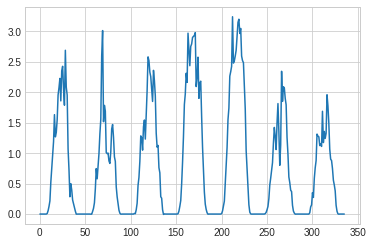

In [21]:
plt.plot(pv_power_pred_rectify)

In [7]:
predicted_df['pv_power_mw'] = pv_power_pred_rectify

In [5]:
mp.predict_pv_power_smooth_and_square_irr()

smooth_phaze : -3
weather dephasage : 1
smooth_phaze : -3


In [6]:
mp.predicted_df

,week,dow,sp,hour,zenith_angle,GHI,POA,demand_MW,temp_location3,temp_location6,...,temp_location4,temp_location5,temp_location1,solar_location3,solar_location6,solar_location2,solar_location4,solar_location5,solar_location1,pv_power_mw
datetime,,,,,,,,,,,,,,,,,,,,,
2020-07-03 00:00:00,27.0,4.0,1.0,0.0,128.823179,0.0,0.0,1.67,12.39,14.270,...,11.410,14.400,12.760,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 00:30:00,27.0,4.0,2.0,0.0,122.069820,0.0,0.0,1.59,12.38,14.230,...,11.370,14.365,12.745,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 01:00:00,27.0,4.0,3.0,1.0,115.237380,0.0,0.0,1.55,12.37,14.190,...,11.330,14.330,12.730,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 01:30:00,27.0,4.0,4.0,1.0,108.358354,0.0,0.0,1.49,12.28,14.170,...,11.460,14.260,12.560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 02:00:00,27.0,4.0,5.0,2.0,101.456678,0.0,0.0,1.48,12.19,14.150,...,11.590,14.190,12.390,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-09 21:30:00,28.0,3.0,44.0,21.0,158.685540,0.0,0.0,2.28,13.97,14.885,...,13.725,14.585,13.300,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-09 22:00:00,28.0,3.0,45.0,22.0,154.141145,0.0,0.0,2.03,13.76,14.680,...,12.980,14.470,13.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-09 22:30:00,28.0,3.0,46.0,22.0,148.561816,0.0,0.0,1.80,13.33,14.535,...,12.440,14.415,12.945,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
bpd = cfbd.BatteryPowerDispatcher
B = bpd.get_all_dispatch_in_a_week(bpd,predicted_df, first_day_pred)
B_final = bpd.format_dispatching_for_competition(B, predicted_df.index)

In [9]:
B.sum()

20200703    1.776357e-15
20200704    6.661338e-16
20200705    1.554312e-15
20200706   -3.552714e-15
20200707   -1.554312e-15
20200708   -4.440892e-16
20200709   -2.886580e-15
dtype: float64

In [40]:
B

,20200703,20200704,20200705,20200706,20200707,20200708,20200709
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.003219,0.000000,0.003709,0.001605,0.002312,0.003336,0.000000
10,0.020033,0.000000,0.002448,0.013940,0.015102,0.013292,0.011116


In [10]:
B_final.to_csv('Output/BGBattery_set4_test.csv')

In [5]:
demand_test_task4_path = 'test/demand_test_set4.csv'
solar_power_test_task4_path = 'test/pv_test_set4.csv'
demand_df = pd.read_csv(demand_test_task4_path,parse_dates=['datetime'],index_col=['datetime'])
solar_power_df = pd.read_csv(solar_power_test_task4_path, parse_dates=['datetime'],index_col=['datetime'])
demand_and_solar_power = pd.merge(demand_df, solar_power_df,  how='outer', left_index=True, right_index=True)
demand_and_solar_power['week']=pd.Int64Index(demand_and_solar_power.index.isocalendar().week)
demand_and_solar_power['dow']=demand_and_solar_power.index.dayofweek
demand_and_solar_power['date'] = demand_and_solar_power.index.date
demand_and_solar_power['hour'] = demand_and_solar_power.index.hour
demand_and_solar_power['sp'] = demand_and_solar_power.hour*2 +demand_and_solar_power.index.minute/30 + 1
cfbd.DataPreprocesser.get_poa_and_ghi_irradiance(cfbd.DataPreprocesser, demand_and_solar_power)

,demand_MW,irradiance_Wm-2,pv_power_mw,panel_temp_C,week,dow,date,hour,sp,GHI,POA
datetime,,,,,,,,,,,
2020-07-03 00:00:00,1.64,0.0,0.0,8.17,27,4,2020-07-03,0,1.0,0.0,0.0
2020-07-03 00:30:00,1.56,0.0,0.0,9.68,27,4,2020-07-03,0,2.0,0.0,0.0
2020-07-03 01:00:00,1.46,0.0,0.0,9.54,27,4,2020-07-03,1,3.0,0.0,0.0
2020-07-03 01:30:00,1.38,0.0,0.0,9.51,27,4,2020-07-03,1,4.0,0.0,0.0
2020-07-03 02:00:00,1.36,0.0,0.0,9.56,27,4,2020-07-03,2,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2020-07-09 21:30:00,2.35,0.0,0.0,11.04,28,3,2020-07-09,21,44.0,0.0,0.0
2020-07-09 22:00:00,2.02,0.0,0.0,11.21,28,3,2020-07-09,22,45.0,0.0,0.0
2020-07-09 22:30:00,1.83,0.0,0.0,12.08,28,3,2020-07-09,22,46.0,0.0,0.0


In [6]:
bpd = cfbd.BatteryPowerDispatcher
B_real = bpd.get_all_dispatch_in_a_week(bpd,demand_and_solar_power, first_day_pred)
B_real_final = bpd.format_dispatching_for_competition(B_real, demand_and_solar_power.index)

In [7]:
B_real.sum()

20200703   -2.664535e-15
20200704    2.664535e-15
20200705    4.440892e-16
20200706   -3.330669e-15
20200707    2.442491e-15
20200708   -3.108624e-15
20200709    2.220446e-15
dtype: float64

In [8]:
B_real_final.to_csv('Output/BGBattery_set4_real.csv')

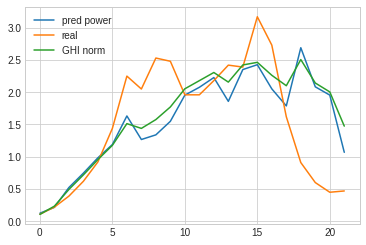

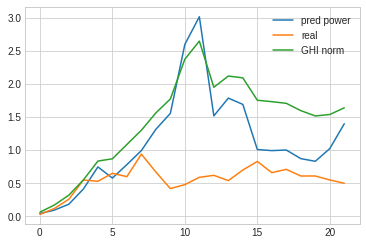

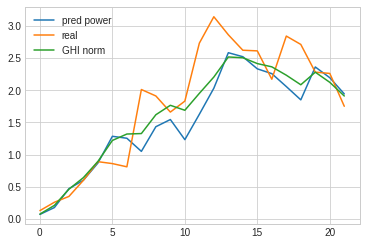

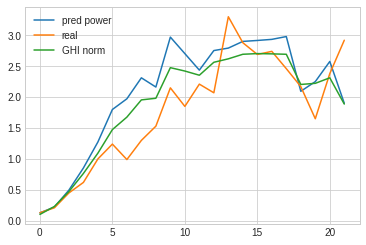

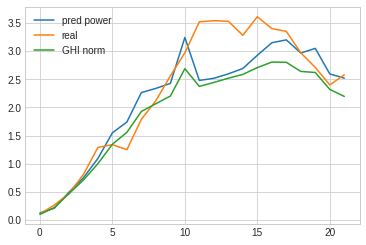

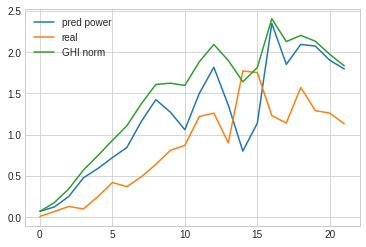

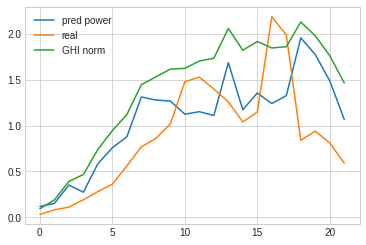

In [34]:
for i in range(7):
    date_pred = first_day_pred + datetime.timedelta(days=i)
    plt.plot(predicted_df.loc[predicted_df.index.date == date_pred, 'pv_power_mw'].values[10:32], label='pred power')
    plt.plot(demand_and_solar_power.loc[demand_and_solar_power.index.date == date_pred, 'pv_power_mw'].values[10:32], label='real')
    plt.plot((predicted_df.loc[predicted_df.index.date == date_pred, 'GHI_normalized'].values[10:32] + predicted_df.loc[predicted_df.index.date == date_pred, 'pv_power_mw'].values[10:32])/2, label= 'GHI norm')
    plt.legend()
    plt.show()

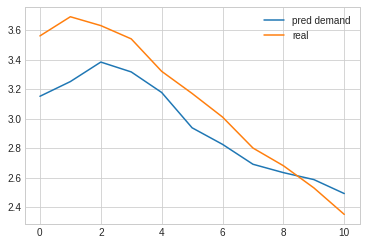

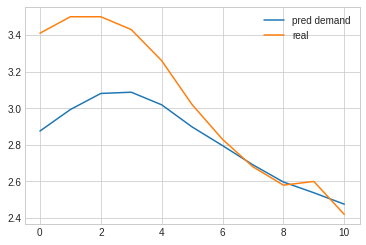

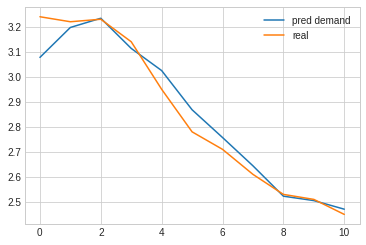

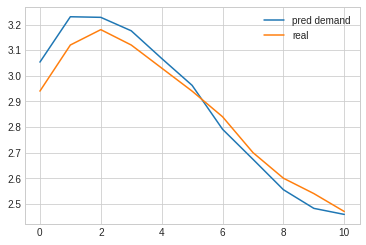

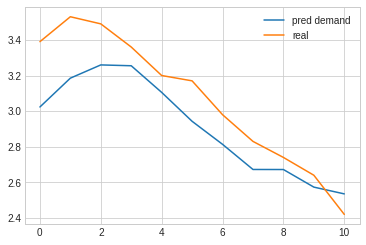

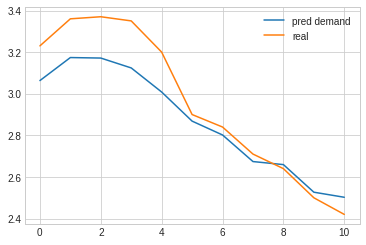

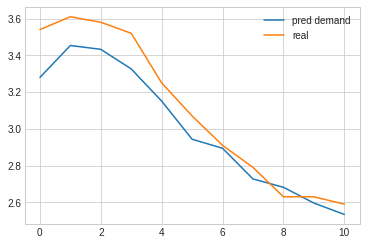

In [26]:
for i in range(7):
    date_pred = first_day_pred + datetime.timedelta(days=i)
    plt.plot(predicted_df.loc[predicted_df.index.date == date_pred, 'demand_MW'].values[32:43], label='pred demand')
    plt.plot(demand_and_solar_power.loc[demand_and_solar_power.index.date == date_pred, 'demand_MW'].values[32:43], label='real')
    plt.legend()
    plt.show()

In [5]:
mp = cfbd.MLPredictor(dp,first_day_pred)
mp.get_demand_previous_week()
mp.get_weather_prediction(weather_path)
mp.get_demand_previous_week()
mp.get_solar_power_previous_week()

,week,dow,sp,hour,zenith_angle,GHI,POA,demand_MW,temp_location3,temp_location6,...,temp_location4,temp_location5,temp_location1,solar_location3,solar_location6,solar_location2,solar_location4,solar_location5,solar_location1,pv_power_mw
datetime,,,,,,,,,,,,,,,,,,,,,
2020-07-03 00:00:00,27.0,4.0,1.0,0.0,128.823179,0.0,0.0,1.67,12.39,14.270,...,11.410,14.400,12.760,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 00:30:00,27.0,4.0,2.0,0.0,122.069820,0.0,0.0,1.59,12.38,14.230,...,11.370,14.365,12.745,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 01:00:00,27.0,4.0,3.0,1.0,115.237380,0.0,0.0,1.55,12.37,14.190,...,11.330,14.330,12.730,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 01:30:00,27.0,4.0,4.0,1.0,108.358354,0.0,0.0,1.49,12.28,14.170,...,11.460,14.260,12.560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-03 02:00:00,27.0,4.0,5.0,2.0,101.456678,0.0,0.0,1.48,12.19,14.150,...,11.590,14.190,12.390,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-09 21:30:00,28.0,3.0,44.0,21.0,158.685540,0.0,0.0,2.28,13.97,14.885,...,13.725,14.585,13.300,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-09 22:00:00,28.0,3.0,45.0,22.0,154.141145,0.0,0.0,2.03,13.76,14.680,...,12.980,14.470,13.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-07-09 22:30:00,28.0,3.0,46.0,22.0,148.561816,0.0,0.0,1.80,13.33,14.535,...,12.440,14.415,12.945,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
bpd = cfbd.BatteryPowerDispatcher
B = bpd.get_all_dispatch_in_a_week(bpd,mp.predicted_df, first_day_pred)
B_final = bpd.format_dispatching_for_competition(B, mp.predicted_df.index)

In [7]:
B_final.to_csv('Output/BGBattery_naive_set4.csv')